## Evaluation of Naive Bayes Classifier for Yelp Reviews -- Kristofer Schobert

We will be making a Naive Bayes Classifier to classify reviews by sentiment (a good review or a bad review). We will calculate an accuracy score for each model via several measures of evaluation. We will then create 5 iterations of the model and discuss the benifits and weaknesses of the models. 

The datasets can be downloaded from https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences

We first train our model:

In [154]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [155]:
data_path = 'yelp_labelled.txt'
df = pd.read_csv(data_path, delimiter= '\t', header=None)
df.columns = ['review', 'sentiment']

The features of this model will be a list of keywords we expect to distinguish good and bad reviews. This is a list of mostly pleased and upset words. Neutral words will give little to no indication if the review is positive or negative.

We will drop any keywords that are not present in any of the training data. 

In [156]:
keywords = ['hate', 'bad', 'horrible', 'terrible', 'poor', 'crappy', 'lousy', 'uncomfortable', 'smelly', 'disgusting',
           'awful', 'wait', 'expensive', 'nasty', 'time', 'wasted', 'disappointing', 'immediately', 'worst', 'won\'t', 
           'happy', 'great', 'best', 'nice', 'lovely', 'charming', 'fantastic', 'helpful', 'tasty', 'wonderful',
           'delicious', 'beautiful','money','bought','care','bring','owners','really','awesome','not','leave','cold',
           'go','were','never','please','hour','minutes','extremely', 'over-priced', '30' ,'45', 'angry' ,'recommend', 
            'didn\'t', 'gross', 'the']
keywords_that_exist = keywords.copy()
print('the features that are not used are...')
for key in keywords:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    df[key] = df.review.str.contains(
        ' ' + str(key) + ' ',
        case=False
    )
    # If a word in keywords is never used, it will get dropped here
    if df[key].nunique() == 1:
        df = df.drop([key], axis=1)
        
        keywords_that_exist.remove(key)
        
        print(key)    

the features that are not used are...
crappy
lousy
uncomfortable
smelly
disgusting
awful
expensive
bought
over-priced
gross


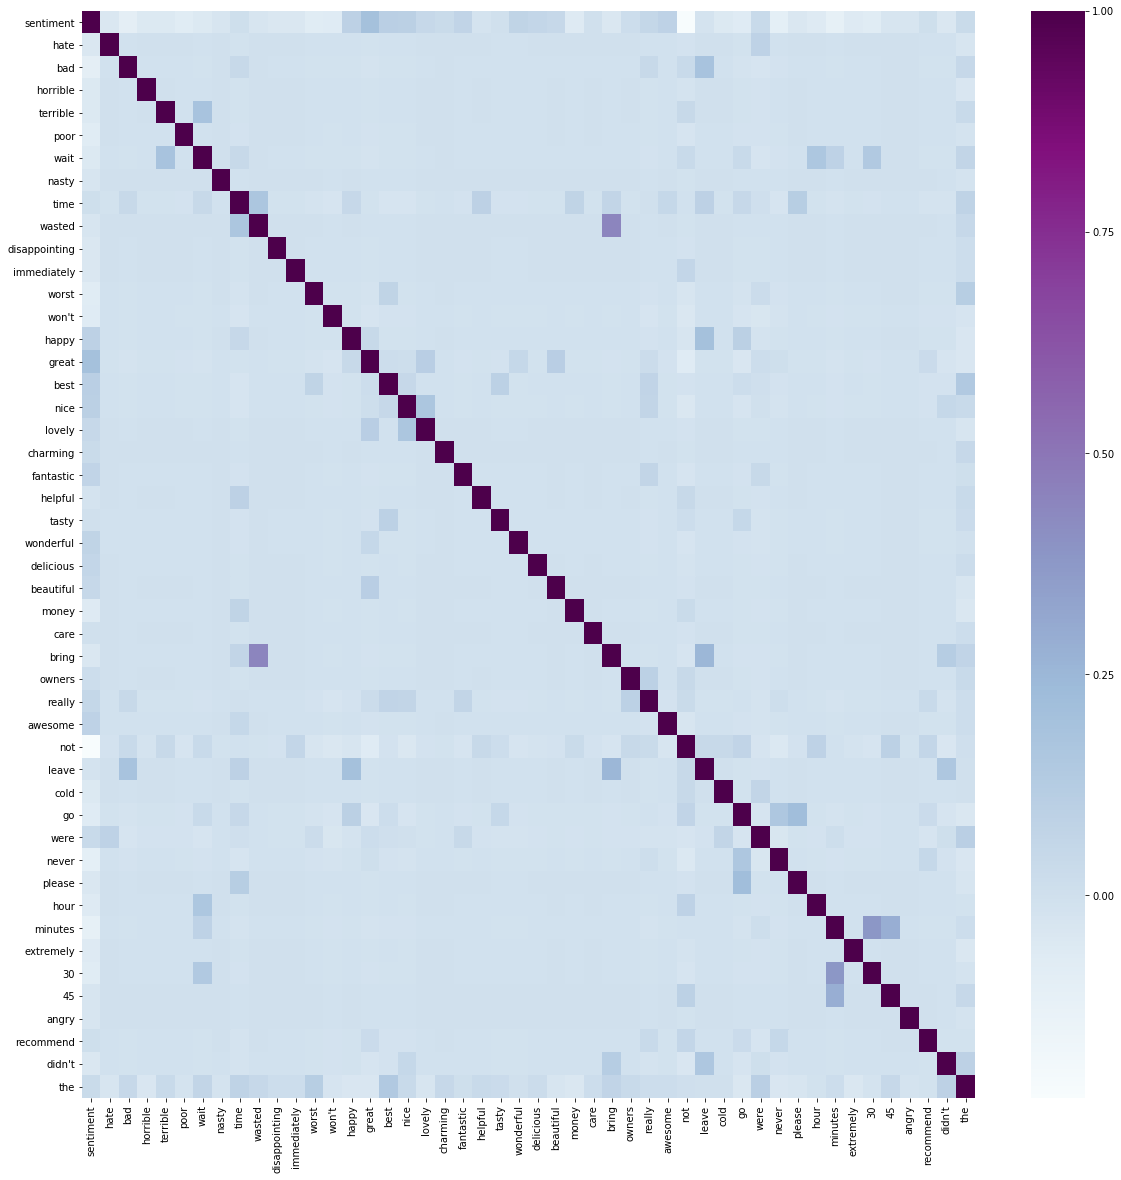

In [157]:
plt.figure(figsize = (20,20))
sns.heatmap(df.corr(),cmap="BuPu")

## Commentary from last assignment

Here we have a correlation table for all the features shown as a heatmap. The first column of the heatmap is significant. It is shows the correlation of each of our features with our outcome variable, sentiment. The words "great" and "awesome" are highly correlated with positive reviews, while "not" is the word most correlated with negative reviews. Also, most all the features have a near zero correlation with eachother. This is what we seek when working with a Naive Bayes Model. We are assuming the features to be conditionally independent from one another. It is worth noting the "poor" and "uncomfortable" have a very high correlation. This is likely because one of the reviews has both of these words, and no other review contains them. While this does seem to violate conditional dependance, I will leave both features in. Our outside knowledge lets us know that both of these words will be most likely used in a negative review, and both words will be useful to have as features when testing our model. 

I at first tried thinking of adjectives that one would use in a positive or negative review. But after some inspection of the reviews, I began to broaden my scope, recognizing that words like "not" were often used in negative reviews. I also tried "the". This word is, of course, common in the data. Our model does not count the number of times a word is used in a review, just whether or not it is used. One might think of someone listing complaints using the word "the" when listing. Still, our model will not use information about the number of uses. We will keep the word "the" as a feature regardless. It does improve the models accuracy some. 

I am aware that this is an large number of features, but they are all valuable and not computationally expensive. It seems one needs a long list of words because of the variability in reviews. There is not a common polarizing word in these reviews, so a long list is necessary. A number of the reviews lack all of these words I have listed here. 

In [159]:
print(keywords_that_exist)


data = df[keywords_that_exist]
target = df['sentiment']


['hate', 'bad', 'horrible', 'terrible', 'poor', 'wait', 'nasty', 'time', 'wasted', 'disappointing', 'immediately', 'worst', "won't", 'happy', 'great', 'best', 'nice', 'lovely', 'charming', 'fantastic', 'helpful', 'tasty', 'wonderful', 'delicious', 'beautiful', 'money', 'care', 'bring', 'owners', 'really', 'awesome', 'not', 'leave', 'cold', 'go', 'were', 'never', 'please', 'hour', 'minutes', 'extremely', '30', '45', 'angry', 'recommend', "didn't", 'the']


In [160]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

Number of mislabeled points out of a total 1000 points : 337


So after training our data on the 1000 Yelp reviews, we have incorrectly classified 337/1000 of the reviews. One bias in this process is that sklearn.naive_bayes defaults to prediciting a positive review if none of the features are present in the review. Thus, a model with no features or with an excellent list of features only correclating strongly with positive reviews one would expect 150/300 successes. It is a real challenge to find common featuers in negative reviews. 


## Let's see a confusion matrix

In [161]:
from sklearn.metrics import confusion_matrix
confusion_matrix(target, y_pred, labels=[0, 1])


array([[199, 301],
       [ 36, 464]])

The structure of the array is:


correctly identified bad review | predicted as a good review when actually a bad review

predicted as a bad review when actually a good review | correctly identified good review



Before we had known we had incorrectly classified 337 samples, and this is see here by taking the sum of the off diagonal elements. We correctly classified 199 of the 199+301=500 bad reviews and 464 of the 36+464=500 good reviews. As I previously stated, the issue here is identifying bad reviews. 

Concidering identifying a good review as our goal, we have only a few false negatives, but many false positives. 

Let's test or data with the holdout function. I had previously done this in the last assignment manually, but let's do this with sklearn's built-in funtion.

In [162]:
# Test your model with different holdout groups.

from sklearn.model_selection import train_test_split
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data, target).score(data, target)))

With 20% Holdout: 0.64
Testing on Sample: 0.663


When training on 80% of the data and testing on 20% we have an accuracy score of 64%... not the best. When we train with our entire sample and test on the entire sample, we have an accuarcy score of 66%... also not good. We are certainly not overfitting. If the score from testing on the entire sample was much higher than the 20% holdout sample, then we could assume overfitting. But these scores are similar and neither are a good score. 

## Lastly, lets see some cross validation for this model.

In [163]:
from sklearn.model_selection import cross_val_score
cv = 9
cvs = cross_val_score(bnb, data, target, cv=cv)
print('With ' + str(cv) + ' folds our cross validation scores are:\n' + str(cvs))
print('The mean and standard deviation of these scores is ' + str(np.mean(cvs)) +', ' +str(np.std(cvs)))



With 9 folds our cross validation scores are:
[0.67857143 0.63392857 0.69642857 0.63392857 0.66964286 0.69090909
 0.65454545 0.60909091 0.65454545]
The mean and standard deviation of these scores is 0.6579545454545455, 0.02727090198660715


All of these scores are within a similar range (the array of scores has a low standard deviation). We still have a roughly 65% accuracy. 

I am aware that removing all the positive adjectives from our keywords list is not the best idea. However, I believe or model will be roughly as accurate with not positive adjectives. Our model assumes the reviews is a good review if none of the keywords are present. Lets see what happens.

# Model #2: No Positive Words (e.g. happy, awesome) in Keyword List

In [176]:
data_path = 'yelp_labelled.txt'
df = pd.read_csv(data_path, delimiter= '\t', header=None)
df.columns = ['review', 'sentiment']

keywords = ['hate', 'bad', 'horrible', 'terrible', 'poor', 'crappy', 'lousy', 'uncomfortable', 'smelly', 'disgusting',
           'awful', 'wait', 'expensive', 'nasty', 'time', 'wasted', 'disappointing', 'immediately', 'worst', 'won\'t', 
           'money','bought','care','bring','owners','really','not','leave','cold',
           'go','were','never','please','hour','minutes','extremely', 'over-priced', '30' ,'45', 'angry' ,'recommend', 
            'didn\'t', 'gross', 'the']
keywords_that_exist = keywords.copy()
print('the features that are not used are...')
for key in keywords:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    df[key] = df.review.str.contains(
        ' ' + str(key) + ' ',
        case=False
    )
    # If a word in keywords is never used, it will get dropped here
    if df[key].nunique() == 1:
        df = df.drop([key], axis=1)
        
        keywords_that_exist.remove(key)
        
        print(key)   

the features that are not used are...
crappy
lousy
uncomfortable
smelly
disgusting
awful
expensive
bought
over-priced
gross


In [177]:

data = df[keywords_that_exist]
target = df['sentiment']

# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

Number of mislabeled points out of a total 1000 points : 344


In [178]:
from sklearn.metrics import confusion_matrix
confusion_matrix(target, y_pred, labels=[0, 1])


array([[198, 302],
       [ 42, 458]])

In [179]:
from sklearn.model_selection import train_test_split
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data, target).score(data, target)))

With 20% Holdout: 0.63
Testing on Sample: 0.656


In [180]:
from sklearn.model_selection import cross_val_score
cv = 9
cvs = cross_val_score(bnb, data, target, cv=cv)
print('With ' + str(cv) + ' folds our cross validation scores are:\n' + str(cvs))
print('The mean and standard deviation of these scores is ' + str(np.mean(cvs)) +', ' +str(np.std(cvs)))



With 9 folds our cross validation scores are:
[0.67857143 0.61607143 0.6875     0.625      0.66071429 0.68181818
 0.65454545 0.6        0.64545455]
The mean and standard deviation of these scores is 0.6499639249639251, 0.029187569088671362


My suspicion was correct. We again have a rougly 65% accruacy score, and the confusion matrix is very close to identical. 

It was of course not a good idea to leave out all words associatied with a favorable review, but when sklearns model assumes a favorable review when no features are present in the sample, we have a serious biasing issue. 

To make our model the best we can using this feature process of finding common words in favorable and unfavorable reviews, we need to know the most common words in these kinds of reviews. We should write some code to list of the most common words in positive and negative reviews. 

# Model 3: Basing the Keywords List off of the Top 25 Most Common Words in the Favorable and Unfavorable Reviews

In [169]:
#finding all the words in all the bad reviews
# making one string of all the bad reviews sperated by a '-'.

all_bad_reviews = '-'.join(df.review[df.sentiment == 0])

#making a list of all the words in this large string containing every bad review sperated by a '-'

import re
list_of_words = re.findall('[A-z]+', all_bad_reviews)
#print(list_of_words)
list_of_lowercase_words = []
for word in list_of_words:
    lowercase_word = word.lower()
    list_of_lowercase_words.append(lowercase_word)
    
## we now have list_of_lowercase_words. this is a list of all the words used in the unfavoriable reviews.
# Let's find our what the most common words are.

number_of_words = 25

import collections
common_bad_review_words = collections.Counter(list_of_lowercase_words).most_common(number_of_words)
print('most common unfavorable words: \n', np.array(common_bad_review_words))



#finding all the words in all the good reviews
# making one string of all the good reviews sperated by a '-'.

all_bad_reviews = '-'.join(df.review[df.sentiment == 1])

#making a list of all the words in this large string containing every bad review sperated by a '-'

import re
list_of_words = re.findall('[A-z]+', all_bad_reviews)
#print(list_of_words)
list_of_lowercase_words = []
for word in list_of_words:
    lowercase_word = word.lower()
    list_of_lowercase_words.append(lowercase_word)
    
## we now have list_of_lowercase_words. this is a list of all the words used in the unfavoriable reviews.
# Let's find our what the most common words are.

import collections
common_good_review_words = collections.Counter(list_of_lowercase_words).most_common(number_of_words)
print('\n' + 'most common favorable words: \n' ,np.array(common_good_review_words))


most common unfavorable words: 
 [['the' '274']
 ['i' '219']
 ['and' '171']
 ['was' '157']
 ['to' '131']
 ['a' '125']
 ['not' '98']
 ['it' '90']
 ['t' '78']
 ['of' '74']
 ['is' '67']
 ['for' '67']
 ['this' '66']
 ['food' '66']
 ['we' '53']
 ['in' '49']
 ['place' '49']
 ['that' '44']
 ['be' '44']
 ['but' '42']
 ['my' '40']
 ['at' '40']
 ['back' '38']
 ['service' '38']
 ['had' '33']]

most common favorable words: 
 [['the' '311']
 ['and' '222']
 ['was' '138']
 ['i' '138']
 ['a' '112']
 ['is' '104']
 ['to' '89']
 ['this' '77']
 ['good' '73']
 ['great' '70']
 ['it' '63']
 ['food' '60']
 ['in' '60']
 ['place' '57']
 ['of' '53']
 ['service' '47']
 ['very' '47']
 ['for' '43']
 ['with' '42']
 ['you' '40']
 ['had' '37']
 ['are' '36']
 ['so' '35']
 ['we' '35']
 ['were' '34']]


Well some neutral words, like 'the', are common in both. I'm happy I spotted 'not' as a common unfavorable word. The word 'I' is used much more often in unfavorable reviews. Perhaps, this is when someone is recounting a bad memory of a restaurant. For whatever reason 'to' is used much more in unfavorable reviews. The letter 't' shows up here, most likely because of our use of regex. This 't' indicates words such as "don't". the letter t will be seperated from don in the code above. This is helpful though. We can search for "'t" in our reviews and that will be an indicator of a unfavorable review. 

In [170]:
list_of_common_bad_words = list(np.array(common_bad_review_words)[:,0])
list_of_common_bad_words.remove('t')
list_of_common_bad_words.append('don\'t')
list_of_common_bad_words.append('won\'t')
list_of_common_bad_words.append('did\'t')
list_of_common_bad_words.append('arn\'t')
list_of_common_bad_words.append('can\'t')
list_of_common_bad_words.append('shouldn\'t')
print(list_of_common_bad_words)



['the', 'i', 'and', 'was', 'to', 'a', 'not', 'it', 'of', 'is', 'for', 'this', 'food', 'we', 'in', 'place', 'that', 'be', 'but', 'my', 'at', 'back', 'service', 'had', "don't", "won't", "did't", "arn't", "can't", "shouldn't"]


In [185]:
#using the most common unfavorable review words. I also included several words that end with "'t".

data_path = 'yelp_labelled.txt'
df = pd.read_csv(data_path, delimiter= '\t', header=None)
df.columns = ['review', 'sentiment']

list_of_common_bad_words = list(np.array(common_bad_review_words)[:,0])
list_of_common_bad_words.remove('t')
list_of_common_bad_words.append('don\'t')
list_of_common_bad_words.append('won\'t')
list_of_common_bad_words.append('did\'t')
list_of_common_bad_words.append('arn\'t')
list_of_common_bad_words.append('can\'t')
list_of_common_bad_words.append('shouldn\'t')
list_of_common_bad_words.append('couldn\'t')


keywords = list_of_common_bad_words

for key in keywords:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    df[key] = df.review.str.contains(
        ' ' + str(key) + ' ',
        case=False
    )
   

In [186]:

data = df[keywords]
target = df['sentiment']

# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))


from sklearn.metrics import confusion_matrix
confusion_matrix(target, y_pred, labels=[0, 1])



from sklearn.model_selection import train_test_split
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data, target).score(data, target)))


from sklearn.model_selection import cross_val_score
cv = 9
cvs = cross_val_score(bnb, data, target, cv=cv)
print('With ' + str(cv) + ' folds our cross validation scores are:\n' + str(cvs))
print('The mean and standard deviation of these scores is ' + str(np.mean(cvs)) +', ' +str(np.std(cvs)))




Number of mislabeled points out of a total 1000 points : 359
With 20% Holdout: 0.625
Testing on Sample: 0.641
With 9 folds our cross validation scores are:
[0.65178571 0.60714286 0.65178571 0.64285714 0.58035714 0.56363636
 0.62727273 0.58181818 0.63636364]
The mean and standard deviation of these scores is 0.6158910533910534, 0.03176894956908188


Ugh... This is a little worse. I really felt good about that idea. I didn't impliment it in the cleanest way though. Maybe, I should look to see what words don't appear in both lists top words. For example, "the" was used in model 3 and that word is top word in both good and bad reviews. While I could be more technical about this (finding the percent difference for the common words in both tables) I will for now just eye-ball it.

I'll leave that for a later model. I'm going to try this again but use the top 100 bad words instead of the top 25 as my keywords

# Model 4: Keywords list is the Top 100 Most Common Unfavorable Words

In [189]:
#finding all the words in all the bad reviews
# making one string of all the bad reviews sperated by a '-'.

all_bad_reviews = '-'.join(df.review[df.sentiment == 0])

#making a list of all the words in this large string containing every bad review sperated by a '-'

import re
list_of_words = re.findall('[A-z]+', all_bad_reviews)
#print(list_of_words)
list_of_lowercase_words = []
for word in list_of_words:
    lowercase_word = word.lower()
    list_of_lowercase_words.append(lowercase_word)
    
## we now have list_of_lowercase_words. this is a list of all the words used in the unfavoriable reviews.
# Let's find our what the most common words are.

number_of_words = 100

import collections
common_bad_review_words = collections.Counter(list_of_lowercase_words).most_common(number_of_words)
#print('most common unfavorable words: \n', np.array(common_bad_review_words))



#finding all the words in all the good reviews
# making one string of all the good reviews sperated by a '-'.

all_bad_reviews = '-'.join(df.review[df.sentiment == 1])

#making a list of all the words in this large string containing every bad review sperated by a '-'

import re
list_of_words = re.findall('[A-z]+', all_bad_reviews)
#print(list_of_words)
list_of_lowercase_words = []
for word in list_of_words:
    lowercase_word = word.lower()
    list_of_lowercase_words.append(lowercase_word)
    
## we now have list_of_lowercase_words. this is a list of all the words used in the unfavoriable reviews.
# Let's find our what the most common words are.

import collections
common_good_review_words = collections.Counter(list_of_lowercase_words).most_common(number_of_words)
#print('\n' + 'most common favorable words: \n' ,np.array(common_good_review_words))

In [190]:
#using the most common unfavorable review words. I also included several words that end with "'t".

data_path = 'yelp_labelled.txt'
df = pd.read_csv(data_path, delimiter= '\t', header=None)
df.columns = ['review', 'sentiment']

list_of_common_bad_words = list(np.array(common_bad_review_words)[:,0])
list_of_common_bad_words.remove('t')
list_of_common_bad_words.append('don\'t')
list_of_common_bad_words.append('won\'t')
list_of_common_bad_words.append('did\'t')
list_of_common_bad_words.append('arn\'t')
list_of_common_bad_words.append('can\'t')
list_of_common_bad_words.append('shouldn\'t')
list_of_common_bad_words.append('couldn\'t')


keywords = list_of_common_bad_words

for key in keywords:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    df[key] = df.review.str.contains(
        ' ' + str(key) + ' ',
        case=False
    )
   

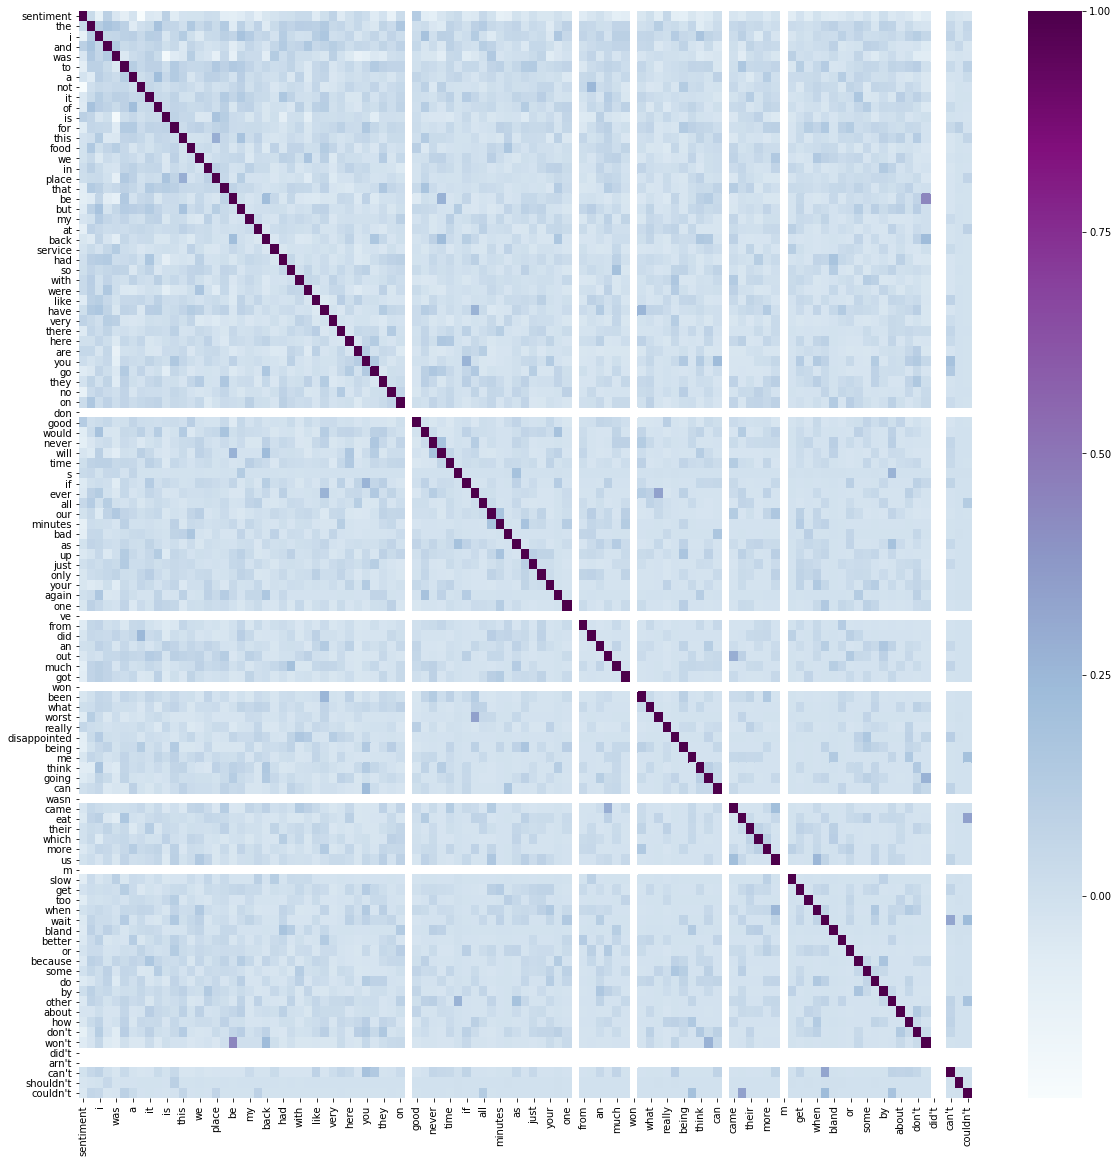

In [196]:
plt.figure(figsize = (20,20))
sns.heatmap(df.corr(),cmap="BuPu")

NOTE: the x-labels of this heatmap are not aligned. 

Here we see a massive heatmap that shows the correlations between the 100 negative keywords being used as features. It seems that "not" is still the word that is most strongly correlated with a negative review. The runner-up looks to be "I". Also, most of these features are not well correlated with another feature. This is good news for our Naive-Bayes model. 

In [191]:

data = df[keywords]
target = df['sentiment']

# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))


from sklearn.metrics import confusion_matrix
confusion_matrix(target, y_pred, labels=[0, 1])



from sklearn.model_selection import train_test_split
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data, target).score(data, target)))


from sklearn.model_selection import cross_val_score
cv = 9
cvs = cross_val_score(bnb, data, target, cv=cv)
print('With ' + str(cv) + ' folds our cross validation scores are:\n' + str(cvs))
print('The mean and standard deviation of these scores is ' + str(np.mean(cvs)) +', ' +str(np.std(cvs)))



Number of mislabeled points out of a total 1000 points : 299
With 20% Holdout: 0.635
Testing on Sample: 0.701
With 9 folds our cross validation scores are:
[0.74107143 0.64285714 0.73214286 0.64285714 0.63392857 0.64545455
 0.70909091 0.56363636 0.68181818]
The mean and standard deviation of these scores is 0.6658730158730158, 0.05282853089900144


Well, it is a little better. I was hoping it would improve more that that... The total number of mislabeled points is now 299 instead of 359. So thats good. And when testing on the whole sample were up to an accuracy of 70% opposed to 64% when only using the top 25 bad words. 


Okay, now to use all that I know. I'll look through the most common bad and good words, choosing words that are common in one list but uncommon in the other. Let's see how this works.

# Model 5: Creating the Keywords List by Inspecting Lists of Common Words In Favorable and Unfavorable Reviews:

## Including words unique to each most common words list and words that are in both lists but used much more often in one list than the other

In [197]:
#finding all the words in all the bad reviews
# making one string of all the bad reviews sperated by a '-'.

all_bad_reviews = '-'.join(df.review[df.sentiment == 0])

#making a list of all the words in this large string containing every bad review sperated by a '-'

import re
list_of_words = re.findall('[A-z]+', all_bad_reviews)
#print(list_of_words)
list_of_lowercase_words = []
for word in list_of_words:
    lowercase_word = word.lower()
    list_of_lowercase_words.append(lowercase_word)
    
## we now have list_of_lowercase_words. this is a list of all the words used in the unfavoriable reviews.
# Let's find our what the most common words are.

number_of_words = 50

import collections
common_bad_review_words = collections.Counter(list_of_lowercase_words).most_common(number_of_words)
print('most common unfavorable words: \n', np.array(common_bad_review_words))



#finding all the words in all the good reviews
# making one string of all the good reviews sperated by a '-'.

all_bad_reviews = '-'.join(df.review[df.sentiment == 1])

#making a list of all the words in this large string containing every bad review sperated by a '-'

import re
list_of_words = re.findall('[A-z]+', all_bad_reviews)
#print(list_of_words)
list_of_lowercase_words = []
for word in list_of_words:
    lowercase_word = word.lower()
    list_of_lowercase_words.append(lowercase_word)
    
## we now have list_of_lowercase_words. this is a list of all the words used in the unfavoriable reviews.
# Let's find our what the most common words are.

import collections
common_good_review_words = collections.Counter(list_of_lowercase_words).most_common(number_of_words)
print('\n' + 'most common favorable words: \n' ,np.array(common_good_review_words))

most common unfavorable words: 
 [['the' '274']
 ['i' '219']
 ['and' '171']
 ['was' '157']
 ['to' '131']
 ['a' '125']
 ['not' '98']
 ['it' '90']
 ['t' '78']
 ['of' '74']
 ['is' '67']
 ['for' '67']
 ['this' '66']
 ['food' '66']
 ['we' '53']
 ['in' '49']
 ['place' '49']
 ['that' '44']
 ['be' '44']
 ['but' '42']
 ['my' '40']
 ['at' '40']
 ['back' '38']
 ['service' '38']
 ['had' '33']
 ['so' '31']
 ['with' '30']
 ['were' '29']
 ['like' '29']
 ['have' '29']
 ['very' '29']
 ['there' '28']
 ['here' '28']
 ['are' '27']
 ['you' '26']
 ['go' '26']
 ['they' '25']
 ['no' '23']
 ['on' '23']
 ['don' '23']
 ['good' '22']
 ['would' '22']
 ['never' '22']
 ['will' '22']
 ['time' '20']
 ['s' '20']
 ['if' '20']
 ['ever' '19']
 ['all' '19']
 ['our' '19']]

most common favorable words: 
 [['the' '311']
 ['and' '222']
 ['was' '138']
 ['i' '138']
 ['a' '112']
 ['is' '104']
 ['to' '89']
 ['this' '77']
 ['good' '73']
 ['great' '70']
 ['it' '63']
 ['food' '60']
 ['in' '60']
 ['place' '57']
 ['of' '53']
 ['servic

In [215]:
# finding words unique to only one of these two lists

unique_common_words = []
for bad_word in np.array(common_bad_review_words)[:,0]:
    if bad_word not in np.array(common_good_review_words)[:,0]:
        unique_common_words.append(bad_word)
for good_word in np.array(common_good_review_words)[:,0]:
    if good_word not in np.array(common_bad_review_words)[:,0]:
        unique_common_words.append(good_word) 
unique_common_words.remove('don')        


print(unique_common_words)        

['at', 'like', 'there', 'no', 'would', 'never', 'will', 'if', 'ever', 'great', 'friendly', 'delicious', 'amazing', 'nice', 'really', 'best', 'just', 'their', 'also']


In [216]:
keywords_with_potential_duplicates = ['i', 'and', 'to', 'not','it','is', 'for', 'we', 'be','but','my', 'no', 'would', 'never', 'go','on'] + unique_common_words

In [222]:

keywords = list(set(keywords_with_potential_duplicates))

data_path = 'yelp_labelled.txt'
df = pd.read_csv(data_path, delimiter= '\t', header=None)
df.columns = ['review', 'sentiment']


for key in keywords:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    df[key] = df.review.str.contains(
        ' ' + str(key) + ' ',
        case=False
    )


In [218]:

data = df[keywords]
target = df['sentiment']

# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))


from sklearn.metrics import confusion_matrix
confusion_matrix(target, y_pred, labels=[0, 1])



from sklearn.model_selection import train_test_split
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data, target).score(data, target)))


from sklearn.model_selection import cross_val_score
cv = 9
cvs = cross_val_score(bnb, data, target, cv=cv)
print('With ' + str(cv) + ' folds our cross validation scores are:\n' + str(cvs))
print('The mean and standard deviation of these scores is ' + str(np.mean(cvs)) +', ' +str(np.std(cvs)))



Number of mislabeled points out of a total 1000 points : 343
With 20% Holdout: 0.64
Testing on Sample: 0.657
With 9 folds our cross validation scores are:
[0.69642857 0.61607143 0.65178571 0.60714286 0.60714286 0.67272727
 0.7        0.6        0.69090909]
The mean and standard deviation of these scores is 0.649134199134199, 0.039674725388284454


ughhhh..... This is roughly no better. It's even a little worse for most all these kinds of scores. I checked to make sure the code is running properly and I'm confident that it is. At lease It seems overfitting is still not an issue. Unfortuantely, it seems fitting is an issue. 

# Conclusion and Future Thoughts


Well, none of my 5 models worked well. I really felt good about the last model, but it was not better than any of the others. This is really difficult. Finding words that are common in the poor reviews is not easy to do. Perhaps, only searching for common words is not the best way to go about it. Maybe, the length of the review, the number of allcaps words, the number of '!'    '...'   '?' could be helpful. I was restricting my modeling to just finding common words seperated by a spacebar. The words with adjacent punctuation (e.g. "again.") were being missed. 

If/when I continue to work on this project, I will start to implement those ideas. Hopefully, they will be more fruitful that when I have done here. 